<a href="https://colab.research.google.com/github/Amplil/genetic_programming/blob/master/genetic_programming_official_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --target "/content/drive/MyDrive/Colab Notebooks/packages" deap

In [ ]:
# !pip install deap

In [ ]:
!apt-get install -y graphviz-dev

'apt-get' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B
  Using cached pygraphviz-1.7.zip (118 kB)
  Running setup.py clean for pygraphviz
Failed to build pygraphviz
    Running setup.py install for pygraphviz: started
    Running setup.py install for pygraphviz: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\hara\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\hara\\AppData\\Local\\Temp\\pip-install-7yn56f96\\pygraphviz_34b45df21dee4b5ab459e8bc5e1c5129\\setup.py'"'"'; __file__='"'"'C:\\Users\\hara\\AppData\\Local\\Temp\\pip-install-7yn56f96\\pygraphviz_34b45df21dee4b5ab459e8bc5e1c5129\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\hara\AppData\Local\Temp\pip-wheel-wpgtu1x3'
       cwd: C:\User

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --target "/content/drive/MyDrive/Colab Notebooks/packages" pygraphviz

^C


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/packages")

In [3]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt

### Graphviz Section ###
import pygraphviz as pgv

import networkx as nx

# [公式ドキュメントGenetic Programming](https://deap.readthedocs.io/en/master/tutorials/advanced/gp.html)のテスト

In [14]:
pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(max, 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addTerminal(3)

In [15]:
pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

In [16]:
pset.addPrimitive(operator.neg, 1)

In [17]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)

In [18]:
tree

In [9]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.renameArguments(ARG0='x')

creator.create("Individual", gp.PrimitiveTree)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)

In [12]:
"""
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")
"""

In [19]:
labels

{0: 'mul', 1: 'sub', 2: 'x', 3: 'x', 4: 'sub', 5: 'x', 6: 'x'}

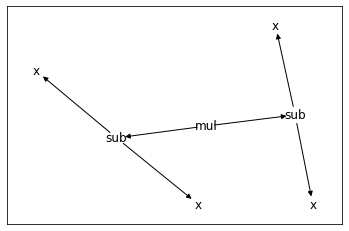

In [20]:
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos=nx.spring_layout(g)
nx.draw_networkx_edges(g,pos)
nx.draw_networkx_labels(g,pos,labels)
plt.show()

# Even-Parity Problem